# The Eight Point Algorithm

In [3]:
from numpy import *
import matplotlib.pyplot as plt
%matplotlib ipympl
from random import randint

It may be useful to change the print options (for numpy) to make output more readable.

In [4]:
set_printoptions(precision=5,floatmode="maxprec",suppress=False)
# set_printoptions(precision=3,floatmode="fixed",suppress=True)

# Camera Configuration

Before we look at the second camera, we have to define the relative pose.  We shift the second camera 10 steps along the $x$ axis and rotate it 30° around the $y$ axis.  Note that the rotation is the standard form (Ma 2004:24) for multiplication with points as column vectors on the right.

[[ 0.86603  0.      -0.5    ]
 [ 0.       1.       0.     ]
 [ 0.5      0.       0.86603]]
[[10]
 [ 0]
 [ 0]]
[[  0   0   0]
 [  0   0 -10]
 [  0  10   0]]


The true essential matrix can be calculated straight away.

[[ 0.       0.       0.     ]
 [-5.       0.      -8.66025]
 [ 0.      10.       0.     ]]


# Point Configuration

We start by defining the eight points in 3D as the `p1` array.  Each row is a point.  These can be visualised for validation.

In [5]:
p1 = array([[369, 115, 1],
            [173, 59, 1],
            [322, 20, 1],
            [269, 263, 1],
            [340, 546, 1],
            [403, 500, 1],
            [326, 497, 1],
            [526, 398, 1]])
p2 = array([[214, 127, 1],
            [124, 75, 1],
            [272, 33, 1],
            [118, 276, 1],
            [289, 560, 1],
            [257, 510, 1],
            [286, 510, 1],
            [352, 406, 1]])


Now, we need the projections in each camera frame.  The first camera is aligned with the world (3D) frame, so the projection is straight forward.  Let `p1_` be the image points in the first camera.

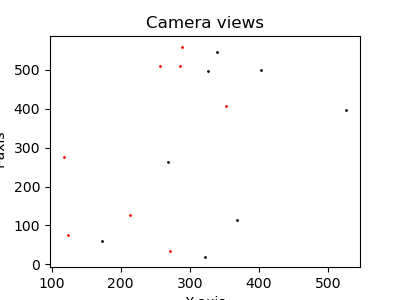

In [7]:

fig = plt.figure(figsize=(4, 3))

ax = fig.add_subplot(111)
for i in range(len(p1)):
    ax.scatter(*p1[i], color="black")
    ax.scatter(*p2[i], color="red")

ax.set_title("Camera views")
ax.set_xlabel("X-axis")
ax.set_ylabel("Y-axis")

plt.show()

Now we calculate the co-ordinates of the 3D points in the second camera frame, by applying the relative pose.  We should check at this point that all the points are visible, that is they have positive $z$-coordinate.

[[ -8.04552  -9.       69.25575]
 [ -5.80385  10.       39.37307]
 [-19.9282   17.       35.83717]
 [-34.95448  -4.       39.86345]
 [-19.25833  -6.       24.67691]
 [ -9.73205  13.       30.17691]
 [-12.00962  15.       68.12178]
 [  7.12436   8.       32.98076]]


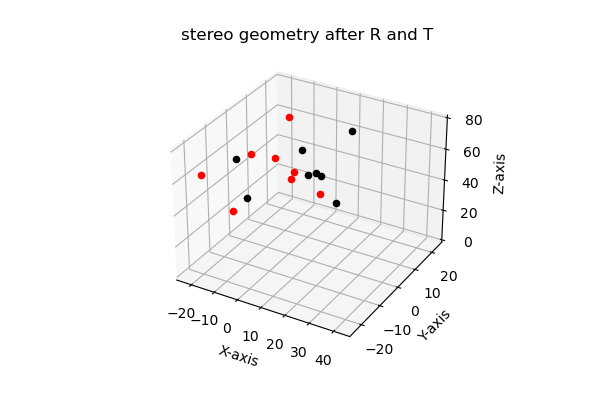

The image points are calculated as we did in the first camera frame.

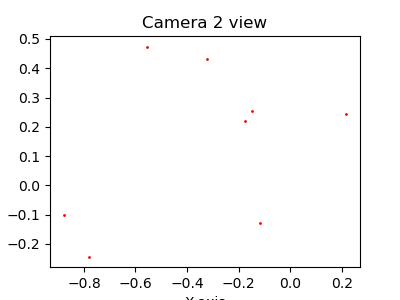

# Finding the Fundamental matrix

In [8]:
xs = [ kron(p1[i], p2[i]) for i in range (len(p1)) ]
chi = vstack(xs)
xs0 = [ (p1[i,newaxis].T @ p2[i,newaxis]).flatten() for i in range (len(p1)) ]
chi0 = vstack(xs0)
print( "Validation should be zero, if the calculations match:", (chi-chi0).max() )
print( "Shape of the chi matrix:", chi.shape)
print(chi)
X = chi.T @ chi
print(X)

Validation should be zero, if the calculations match: 0
Shape of the chi matrix: (8, 9)
[[ 78966  46863    369  24610  14605    115    214    127      1]
 [ 21452  12975    173   7316   4425     59    124     75      1]
 [ 87584  10626    322   5440    660     20    272     33      1]
 [ 31742  74244    269  31034  72588    263    118    276      1]
 [ 98260 190400    340 157794 305760    546    289    560      1]
 [103571 205530    403 128500 255000    500    257    510      1]
 [ 93236 166260    326 142142 253470    497    286    510      1]
 [185152 213556    526 140096 161588    398    352    406      1]]
[[ 1421112193  -775581612   272522697 -1447091708  1946420466   245910832
    193981063   253857528      699963]
 [ -775581612   819078490   357026136  1946420466   141419930   400243370
    253857528   410707364      920454]
 [  272522697   357026136     1003096   245910832   400243370      888339
       699963      920454        2728]
 [-1447091708  1946420466   245910832  12899

We do the SVD decomposition of $\chi$ (aka. `X`). 
We need to specify `full_matrices=False` to get the right dimensions, 
so that we can reconstruct the matrix for validation.

In [9]:
ux, sx, vhx = linalg.svd(X,full_matrices=False)
print( "vhx should have shape 8x9. Actual shape is", vhx.shape)
Xreconstructed = ux @ diag(sx) @ vhx
print( "Validation - should be zero if the reconstruction is correct:", (X - Xreconstructed).max())

vhx should have shape 8x9. Actual shape is (9, 9)
Validation - should be zero if the reconstruction is correct: 7.3909759521484375e-06


The diagonal matrix $\Sigma_\chi$ (`sx`) should contain the singular values in descending order.

In [10]:
print(sx)

[4.16085e+09 3.09622e+09 1.58904e+09 7.73883e+08 3.93615e+08 4.39158e+06
 2.04364e+04 1.19344e+02 6.36205e-03]


Let's inspect the other two matrices as well:

In [11]:
print(ux)
print(vhx)

[[-6.02587e-01 -4.08160e-01  5.48257e-01  4.02480e-01  8.05693e-02
   3.50234e-02 -5.15088e-05  3.86695e-05 -8.08694e-08]
 [ 4.83796e-01 -3.36968e-01 -2.63984e-01  6.62978e-01  3.75471e-01
   4.67322e-02  1.93696e-03 -3.42586e-06  3.03368e-07]
 [ 1.54387e-02 -1.89192e-01  2.04170e-02 -3.18304e-01  2.94099e-01
   7.23227e-01  5.02637e-01  5.88208e-03 -1.62864e-03]
 [ 5.92203e-01 -3.64320e-01  5.55029e-01 -1.51557e-01 -4.30533e-01
  -1.31105e-02 -3.06517e-03 -4.86079e-05 -2.90692e-07]
 [-2.24784e-01 -6.59511e-01 -5.60245e-01 -1.54250e-01 -4.17533e-01
  -5.01616e-02  2.20387e-04  1.37632e-05 -3.51832e-08]
 [ 2.46566e-02 -2.17870e-01  5.91564e-02 -3.12086e-01  4.16479e-01
  -4.13223e-01  5.99643e-02  7.07653e-01  4.95071e-02]
 [ 1.10673e-02 -1.37510e-01  1.65931e-02 -2.23228e-01  2.26378e-01
   3.71371e-01 -8.61106e-01  1.39859e-02  7.22428e-04]
 [ 2.50874e-02 -2.23616e-01  6.00314e-02 -3.21186e-01  4.26193e-01
  -4.02706e-01  4.73596e-02 -7.02919e-01 -4.95115e-02]
 [ 3.86484e-05 -4.95504e

In [13]:
Es = vhx.T[:, -1]
E = Es.reshape(3, 3).T
print(E)

[[-8.08694e-08 -2.90692e-07  7.22428e-04]
 [ 3.03368e-07 -3.51832e-08 -4.95115e-02]
 [-1.62864e-03  4.95071e-02  9.97544e-01]]


The recovered essential matrix `E` should match the ground truth `Etrue`.
This currently fails.

## Validations


In [14]:
X @ Es

array([ 1.39698e-09, -8.14907e-09, -1.03616e-05, -8.20728e-09,
       -3.60887e-09,  3.14966e-04,  4.59576e-06, -3.14993e-04,
        6.34642e-03])

Since `Es` should be the solution of $\chi E^s=0$, the above should be the zero vector.  It does not look too bad, with $0.00542$ the largest element, but given that the original data are exact, with no noise, it should have been better.

# Normalising the Essential Matrix

In [15]:
u, s, vh = linalg.svd(E)
print(u)
print(s)
print(vh)

[[-7.21531e-04  1.46892e-02 -9.99892e-01]
 [ 4.94510e-02 -9.98668e-01 -1.47069e-02]
 [-9.98776e-01 -4.94563e-02 -5.82469e-06]]
[9.99997e-01 2.45272e-03 8.59316e-08]
[[ 1.62667e-03 -4.94467e-02 -9.98775e-01]
 [ 3.27156e-02 -9.98239e-01  4.94734e-02]
 [ 9.99463e-01  3.27560e-02  6.12617e-06]]


In [16]:
Ees = u @ diag([1, 1, 0]) @ vh
#Ees = -Ees
U, S, Vh = linalg.svd(Ees)
print(U)
print(S)
print(Vh)
print(Ees)

[[ 1.45011e-03  1.46352e-02  9.99892e-01]
 [-9.89840e-02 -9.94980e-01  1.47069e-02]
 [ 9.95088e-01 -9.89946e-02  5.82469e-06]]
[1.00000e+00 1.00000e+00 1.01445e-17]
[[ 0.00000e+00 -1.87024e-04  1.00000e+00]
 [ 3.27560e-02 -9.99463e-01 -1.86924e-04]
 [ 9.99463e-01  3.27560e-02  6.12617e-06]]
[[ 4.79392e-04 -1.46276e-02  1.44737e-03]
 [-3.25916e-02  9.94465e-01 -9.87980e-02]
 [-3.24267e-03  9.87554e-02  9.95106e-01]]


# Recovering the Relative Pose

In [17]:
R = array([[0, 1, 0],
             [-1, 0, 0],
             [0, 0, 1]])
RR = U @ R @ Vh
TR_ = U @ R @ diag([1, 1, 0]) @ U.T

RT = U @ R.T @ Vh
TT_ = U @ R.T @ diag([1, 1, 0]) @ U.T

print(RR)
print(RT)
print("---------------------")
print(TR_)
print(TT_)

[[ 0.9994   0.03131 -0.01463]
 [ 0.01146  0.09923  0.995  ]
 [ 0.0326  -0.99457  0.09881]]
[[ 0.99931  0.0342   0.01464]
 [ 0.01794 -0.09826 -0.995  ]
 [-0.03259  0.99457 -0.09881]]
---------------------
[[ 0.00000e+00  5.82469e-06 -1.47069e-02]
 [-5.82469e-06  0.00000e+00  9.99892e-01]
 [ 1.47069e-02 -9.99892e-01  0.00000e+00]]
[[ 0.00000e+00 -5.82469e-06  1.47069e-02]
 [ 5.82469e-06  0.00000e+00 -9.99892e-01]
 [-1.47069e-02  9.99892e-01  0.00000e+00]]


In [19]:
print(Ry)
print(T)

[[ 0.86603  0.      -0.5    ]
 [ 0.       1.       0.     ]
 [ 0.5      0.       0.86603]]
[[10]
 [ 0]
 [ 0]]


In [20]:
E1 = dot(TR_, RR)
E2 = dot(TR_, RT)
E3 = dot(TT_, RT)
E4 = dot(TT_, RR)
print( E )
print( E1 )
print( E2 )
print( E3 )
print( E4 )


[[-1.00871e-14  3.82563e-14 -1.82354e-14]
 [-3.53553e-01  2.92370e-14 -6.12372e-01]
 [ 1.86101e-14  7.07107e-01 -8.16014e-15]]
[[ 1.46549e-14 -5.44009e-14  2.53831e-14]
 [ 5.00000e-01 -2.22857e-14  8.66025e-01]
 [-3.58602e-14 -1.00000e+00 -5.10174e-15]]
[[-1.46549e-14  5.44009e-14 -2.53831e-14]
 [-5.00000e-01  2.22857e-14 -8.66025e-01]
 [ 3.58602e-14  1.00000e+00  5.10174e-15]]
[[ 1.46549e-14 -5.44009e-14  2.53831e-14]
 [ 5.00000e-01 -2.22857e-14  8.66025e-01]
 [-3.58602e-14 -1.00000e+00 -5.10174e-15]]
[[-1.46549e-14  5.44009e-14 -2.53831e-14]
 [-5.00000e-01  2.22857e-14 -8.66025e-01]
 [ 3.58602e-14  1.00000e+00  5.10174e-15]]
